# Superimpose data

The aim of this notebook is to indicate how to superimpose data from different sources (radar, satellite, weather models...).

There are 2 data categories :
* data projected on a grid (radar, weather models...)
* punctual data like observations from ground stations

So, this notebook provides functions which allow to :
* superimpose 2 grids of different resolutions
* superimpose data on a grid with punctual data

# I - Superimpose 2 grids of different resolutions

## I.1 - 2 GRIB files 
### Example : 3D ARPEGE data on isobaric levels (0.1°) to interpolate to 2D AROME data on the 2m level (0.025°)
#### Use xarray to open GRIB files and perform interpolation

In [1]:
import meteonet_toolbox.user_configuration
import xarray as xr
import datetime as dt
%matplotlib notebook
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import colors
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

User is not known. If you experiment some problems with path for library please add the specific path in `user_configuration.py` module


In [2]:
####Cell containing the modifiable fields######
zone = "SE"     #geographic zone (NW or SE)
arp_param = 't'    #arpege : parameter name in the file (cf cells below to know the parameter names -> exploration of metadata)
aro_param = 't2m' #arome : parameter name in the file (cf cells below to know the parameter names -> exploration of metadata)
date = dt.datetime(2018, 5, 1,0,0) # Day example 
time_step = 0                #index for the studied time step 
level_step = 0               #index for the studied level step (from ground upwards)

arp_fname = "../../data_samples/weather_models/arpege_3D_isobar_%s_%s.grib" % (zone,date.strftime('%Y%m%d%H%M%S'))
aro_fname = "../../data_samples/weather_models/arome_2m_%s_%s.grib" % (zone,date.strftime('%Y%m%d%H%M%S'))

Interpolation parameters (fname and parameter for each dataset : data to interpolate and target data):

In [3]:
#ori : for original, data to interpolate
ori_fname = arp_fname
ori_param = arp_param
#tar : for target, which corresponds to the target grid
tar_fname = aro_fname
tar_param = aro_param

Load the data:

In [4]:
data_to_interpolate = xr.open_dataset(arp_fname, engine='cfgrib')  
target_data = xr.open_dataset(aro_fname, engine='cfgrib')  

Perform the interpolation:

In [5]:
#today, with the function above, 2 interpolation methods are implemented for 2D arrays : 'linear' and 'nearest' for nearest neighbors
interpolated_data = data_to_interpolate.interp_like(target_data,method='linear')

Plot the different data:

<IPython.core.display.Javascript object>


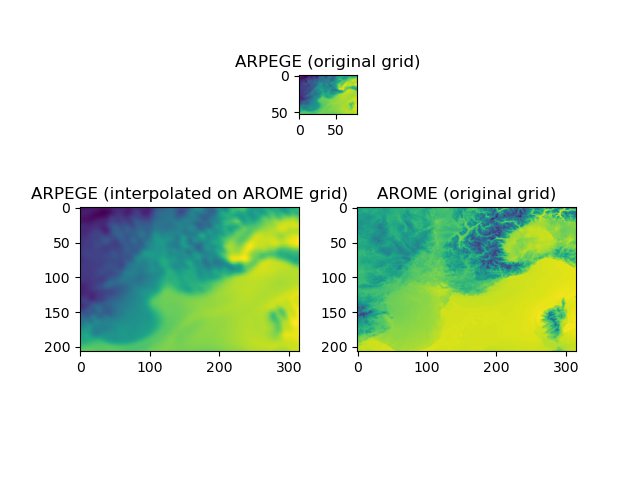

In [6]:
#/!\#### the plots options depend on the GRIB file structure (for example, 'isobaricInhPa =' means we have a 3D grib file with isobaric levels)        
fig = plt.figure()
widths = [9,2.4, 9]
heights = [2.25, 9]
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths,
                         height_ratios=heights)
ax = fig.add_subplot(spec[0,1])

#data to interpolate
fig.subplots_adjust(wspace=0, hspace=0)
label = 'Width: {}\nHeight: {}'.format(widths[1], heights[0])
ax.annotate('', (0.1, 0.5), xycoords='axes fraction', va='center')
plt.imshow(data_to_interpolate.isel(step=time_step, isobaricInhPa = level_step)[ori_param].values)
if ori_fname == arp_fname:
    ax.set_title('ARPEGE (original grid)')
else:
    ax.set_title('AROME (original grid)')

#interpolated data
ax = fig.add_subplot(spec[1,0])
fig.subplots_adjust(wspace=0, hspace=0)
label = 'Width: {}\nHeight: {}'.format(widths[0], heights[1])
ax.annotate('', (0.1, 0.5), xycoords='axes fraction', va='center')
plt.imshow(interpolated_data.isel(step=time_step, isobaricInhPa = level_step)[ori_param].values)
if ori_fname == arp_fname:
    ax.set_title('ARPEGE (interpolated on AROME grid)')
else:
    ax.set_title('AROME (interpolated on ARPEGE grid)')

#data with the target grid    
ax = fig.add_subplot(spec[1,2])
fig.subplots_adjust(wspace=0, hspace=0)
label = 'Width: {}\nHeight: {}'.format(widths[2], heights[1])
ax.annotate('', (0.1, 0.5), xycoords='axes fraction', va='center')
im=plt.imshow(target_data.isel(step=time_step)[tar_param].values)
if tar_fname == arp_fname:
    ax.set_title('ARPEGE (original grid)')
else:
    ax.set_title('AROME (original grid)')

## I.2 - 1 GRIB file and 1 radar file
### Example : rainfall data (NPZ file, 0.01°) to interpolate to land-sea mask (GRIB file, 0.025°)

In [7]:
####Cell containing the modifiable fields######
year = 2016
month = 8
decade = 3
ind = 15   #index of the chosen 5 min of the decade 
nan_value = -1  #nan value for data (ex : rainfall here)

rain_param = 'rainfall'    #parameter name for rainfall
mask_param = 'lsm'         #parameter name for land-sea mask (cf meta-data in the mask GRIB file)

rain_fname = "../../data_samples/radar/rainfall_%s_%s_%s.%s.npz" % (zone, str(year),"{:02d}".format(month),str(decade))
rain_coords_fname = "../../data_samples/radar/radar_coords_%s.npz" % (zone)
mask_fname = "../../data_samples/masks/%s_masks.grib" % (zone)

#### Step 1 : put NPZ data into an xarray (values, lat, lon)

In [8]:
def radar_to_grib(rain_fname,rain_coords_fname,ind):
    
    #load data
    d = np.load(rain_fname, allow_pickle=True)
    data = d['data'][ind,:,:]
    
    coords = np.load(rain_coords_fname, allow_pickle=True)
    #it is about coordinates of the center of pixels 
    lat = coords['lats']
    lon = coords['lons']
    
    data = xr.DataArray(data,coords=[lat[:,0],lon[0,:]],dims=['latitude','longitude'])
    d_grib = data.to_dataset(name = 'rainfall')
    
    return d_grib,lat,lon

In [9]:
d_grib,lat,lon = radar_to_grib(rain_fname,rain_coords_fname,ind)

#### Step 2 : perform the interpolation
**/!\ if the 'missing data' value is not nan (for example it is -1 for rainfall), it is necessary to convert these values before into nan if you want to use the linear interpolation method, else use the nearest neighbors method**

Interpolation parameters (fname and parameter for each dataset : data to interpolate and target data):

In [10]:
#ori : for original, data to interpolate
ori_data = d_grib
ori_param = rain_param
#tar : for target, which corresponds to the target grid
tar_fname = mask_fname
tar_param = mask_param
#nan value
nan_value = -1  #nan value for data (ex : rainfall here)

Load the target data and the data to interpolate:

In [11]:
data_to_interpolate = d_grib
target_data = xr.open_dataset(tar_fname, engine='cfgrib') 
np.unique(d_grib['rainfall'].values)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  73,  74,  75,  77,  78,
        79,  80,  82,  83,  84,  85,  86,  87,  88,  89,  91,  92,  93,
        94,  95,  97,  98, 101, 103, 106, 107, 108, 109, 110, 111, 112,
       115, 116, 118, 122, 123, 124, 125, 129, 133, 136, 137, 138, 139,
       142, 144, 145, 152, 153, 154, 157, 160, 162, 163, 164, 168, 169,
       171, 172, 174, 178, 181, 184, 187, 191, 196, 200, 202], dtype=int16)

Perform the interpolation:

In [12]:
# convert missing data (from value to 'nan')
nan_data_to_interpolate = data_to_interpolate.where(data_to_interpolate["rainfall"]!=nan_value)  
#today, with the function above, 2 interpolation methods are implemented for 2D arrays : 'linear' and 'nearest' for nearest neighbors
interpolated_data = nan_data_to_interpolate.interp_like(target_data,method='linear')    

Plot the different data:

<IPython.core.display.Javascript object>


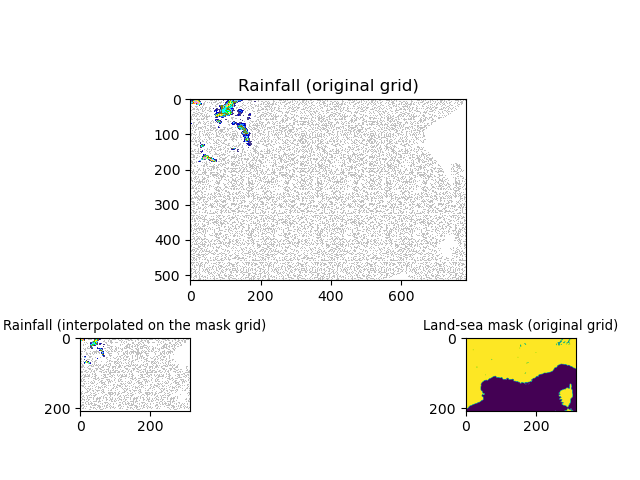

Text(0.5, 1.0, 'Land-sea mask (original grid)')

In [13]:
#/!\#### the plots options depend on the GRIB file structure###
fig = plt.figure()
widths = [3.6,9, 3.6]
heights = [9, 3.6]
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths,
                         height_ratios=heights)
ax = fig.add_subplot(spec[0,1])

#colorbar definition for rainfall
if (np.max(data_to_interpolate[ori_param].values) > 65):
    borne_max = np.max(data_to_interpolate[ori_param].values)
else:
    borne_max = 65 + 10
cmap = colors.ListedColormap(['silver','white', 'darkslateblue', 'mediumblue','dodgerblue', 'skyblue','olive','mediumseagreen'
                              ,'cyan','lime','yellow','khaki','burlywood','orange','brown','pink','red','plum'])
bounds = [-1,0,2,4,6,8,10,15,20,25,30,35,40,45,50,55,60,65,borne_max]
norm = colors.BoundaryNorm(bounds, cmap.N)

#data to interpolate with nan
fig.subplots_adjust(wspace=0, hspace=0)
label = 'Width: {}\nHeight: {}'.format(widths[1], heights[0])
ax.annotate('', (0.1, 0.5), xycoords='axes fraction', va='center')
plt.imshow(nan_data_to_interpolate[ori_param].values,cmap=cmap, norm=norm)
ax.set_title('Rainfall (original grid)')

#interpolated data
ax = fig.add_subplot(spec[1,0])
fig.subplots_adjust(wspace=0, hspace=0)
label = 'Width: {}\nHeight: {}'.format(widths[0], heights[1])
ax.annotate('', (0.1, 0.5), xycoords='axes fraction', va='center')
plt.imshow(interpolated_data[ori_param].values,cmap=cmap, norm=norm) 
ax.set_title('Rainfall (interpolated on the mask grid)',fontsize = 9.5)

#data with the target grid
ax = fig.add_subplot(spec[1,2])
fig.subplots_adjust(wspace=0, hspace=0)
label = 'Width: {}\nHeight: {}'.format(widths[2], heights[1])
ax.annotate('', (0.1, 0.5), xycoords='axes fraction', va='center')
plt.imshow(target_data[tar_param].values) 
ax.set_title('Land-sea mask (original grid)',fontsize = 9.5)

# II - Superimpose data on a grid with punctual data

### Example 1 : 2D AROME data on the 2m level (GRIB file, 0.025°) to interpolate to ground station observations

In [14]:
####Cell containing the modifiable fields######
date = '2016-01-01T06:00:00'    #study date 
obs_param = 't'      #observation parameter
grib_param = 't2m'   #AROME parameter
grib_time_step = 0  #index for the studied time step 

In [15]:
study_date = pd.Timestamp(date)  #study date
fname = "../../data_samples/ground_stations/%s_20160101.csv"%zone
df =pd.read_csv(fname,parse_dates=[4],infer_datetime_format=True)
d_sub = df[df['date'] == study_date]

Overview of observation data for a given date :

In [16]:
display(d_sub.head())

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
28830,1027003,45.83,5.11,196.0,2016-01-01 06:00:00,NaN,NaN,NaN,99.0,276.45,276.55,NaN
28831,1033002,46.09,5.81,350.0,2016-01-01 06:00:00,360.0,0.5,0.0,99.0,276.25,276.35,NaN
28832,1034004,45.77,5.69,330.0,2016-01-01 06:00:00,360.0,1.2,0.0,100.0,277.15,277.15,NaN
28833,1072001,46.20,5.29,260.0,2016-01-01 06:00:00,NaN,NaN,0.0,NaN,NaN,272.95,NaN
28834,1089001,45.98,5.33,252.0,2016-01-01 06:00:00,40.0,1.2,0.0,97.0,276.75,277.15,102700.0


Load AROME data : parameter values, latitudes and longitudes

In [17]:
aro = xr.open_dataset(aro_fname, engine='cfgrib')
grid_lat = aro['latitude'].values
grid_lon = aro['longitude'].values
grid_val = aro[grib_param].values

Perform the interpolation

In [18]:
def interpolate_grib_on_points(grid_lat,grid_lon,grid_val,data_obs):
    
    #initialisation
    latlon_grid = []
    latlon_obs = []
    val_grid = []
    
    #grid data preprocessing
    for i in range(0,grid_lat.shape[0]):        
        for j in range(0,grid_lon.shape[0]):
            #put coordinates (lat,lon) in list of tuples
            latlon_grid.append([round(grid_lat[i],3),round(grid_lon[j],3)])
            #put grid values into a list
            val_grid.append(grid_val[time_step,i,j])
    grid_latlon = np.array(latlon_grid)
    grid_val2 = np.array(val_grid)

    #obs data preprocessing : put coordinates (lat,lon) in list of tuples
    for i in range(0,data_obs.shape[0]):
        latlon_obs.append([data_obs['lat'].values[i],data_obs['lon'].values[i]])
    latlon_obs = np.array(latlon_obs)
    
    #interpolation
    grid_val_on_points=griddata(grid_latlon ,grid_val2, latlon_obs,  method='linear')
    return latlon_obs,grid_val_on_points

In [19]:
latlon_obs,grid_val_on_points = interpolate_grib_on_points(grid_lat,grid_lon,grid_val,d_sub)

Plot the different data:

<IPython.core.display.Javascript object>


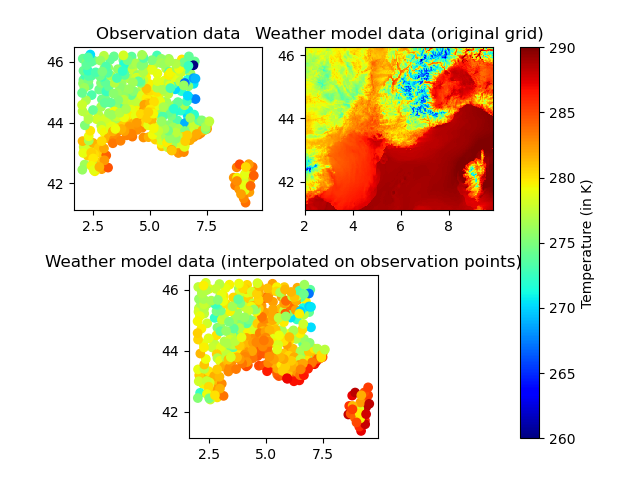

In [20]:
fig=plt.figure()
gs = gridspec.GridSpec(4, 4)

#observation data
ax1 = plt.subplot(gs[:2, :2])
plt.tight_layout(pad=3.0)
im=ax1.scatter(d_sub['lon'], d_sub['lat'], c=d_sub[obs_param], cmap='jet',vmin=260,vmax=290)
ax1.set_title('Observation data')

#weather model data (original grid)
ax2 = plt.subplot(gs[:2, 2:])
ax2.pcolor(grid_lon,grid_lat,aro.isel(step=grib_time_step)[grib_param].values,cmap="jet",vmin=260,vmax=290)
ax2.set_title('Weather model data (original grid)')

#weather model data (interpolated on observation points)
ax3 = plt.subplot(gs[2:4, 1:3])
ax3.scatter(latlon_obs[:,1], latlon_obs[:,0], c=grid_val_on_points, cmap='jet',vmin=260,vmax=290)
ax3.set_title('Weather model data (interpolated on observation points)')

fig.colorbar(im,ax=[ax1,ax2,ax3]).set_label('Temperature (in K)')
plt.show()

### Example 2 : radar data (rainfall, NPZ file, 0.01°) to interpolate to ground station observations

In [21]:
####Cell containing the modifiable fields######
###obs###
date = '2016-01-01 16:30:00'    #study date 
obs_param = 'precip'      #observation parameter
npz_param = 'rainfall'   #npz parameter

#rainfall##
year = 2016
month = 8
decade = 3
ind = 15   #index of the chosen 5 min of the decade 
nan_value = -1  #nan value for data (ex : rainfall here)

rain_fname = "../../data_samples/radar/rainfall_%s_%s_%s.%s.npz" % (zone, str(year),"{:02d}".format(month),str(decade))
rain_coords_fname = "../../data_samples/radar/radar_coords_%s.npz" % (zone)

In [22]:
study_date = pd.Timestamp(date)  #study date
fname = "../../data_samples/ground_stations/%s_20160101.csv"%zone
df =pd.read_csv(fname,parse_dates=[4],infer_datetime_format=True)
d_sub = df[df['date'] == study_date]

Overview of observation data for a given date :

In [23]:
display(d_sub.head())

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
75889,1027003,45.83,5.11,196.0,2016-01-01 16:30:00,NaN,NaN,NaN,97.0,279.75,280.15,NaN
75890,1033002,46.09,5.81,350.0,2016-01-01 16:30:00,100.0,1.4,0.0,78.0,276.85,280.45,NaN
75891,1034004,45.77,5.69,330.0,2016-01-01 16:30:00,50.0,2.3,0.0,79.0,277.45,280.85,NaN
75892,1072001,46.20,5.29,260.0,2016-01-01 16:30:00,NaN,NaN,0.0,NaN,NaN,277.65,NaN
75893,1089001,45.98,5.33,252.0,2016-01-01 16:30:00,360.0,0.9,0.0,96.0,277.45,278.05,102060.0


Load radar data : parameter values, latitudes and longitudes

In [24]:
radar = np.load(rain_fname, allow_pickle=True)
data = radar['data'][ind,:,:]
coords = np.load(rain_coords_fname, allow_pickle=True)
#it is about coordinates of the center of pixels
lat = coords['lats']
lon = coords['lons']

#### Perform the interpolation
**/!\ if the 'missing data' value is not nan (for example it is -1 for rainfall), it is necessary to convert these values before into nan if you want to use the linear interpolation method, else use the nearest neighbors method**

In [25]:
def interpolate_radar_on_points(grid_lat,grid_lon,grid_val,data_obs):
    #grid data preprocessing
    latlon_grid = []
    latlon_obs = []
    val_grid = []
    for i in range(0,grid_lat.shape[0]):        
        for j in range(0,grid_lon.shape[1]):
            #put coordinates (lat,lon) in list of tuples
            latlon_grid.append([grid_lat[i,0],grid_lon[0,j]])
            #put grid values into a list
            val_grid.append(grid_val[i,j])
    grid_latlon = np.array(latlon_grid)
    grid_val2 = np.array(val_grid)
    #replace 'missing data' values by nan
    grid_val2 = grid_val2.astype(np.float64)
    grid_val2[grid_val2==-1]=np.nan

    #obs data preprocessing : put coordinates (lat,lon) in list of tuples
    for i in range(0,data_obs.shape[0]):
        latlon_obs.append([data_obs['lat'].values[i],data_obs['lon'].values[i]])
    latlon_obs = np.array(latlon_obs)

    #interpolation
    grid_val_on_points=griddata(grid_latlon ,grid_val2, latlon_obs,  method='linear')
    return latlon_obs,grid_val_on_points

In [26]:
latlon_obs,grid_val_on_points = interpolate_radar_on_points(lat,lon,data,d_sub)

Plot the different data:

<IPython.core.display.Javascript object>


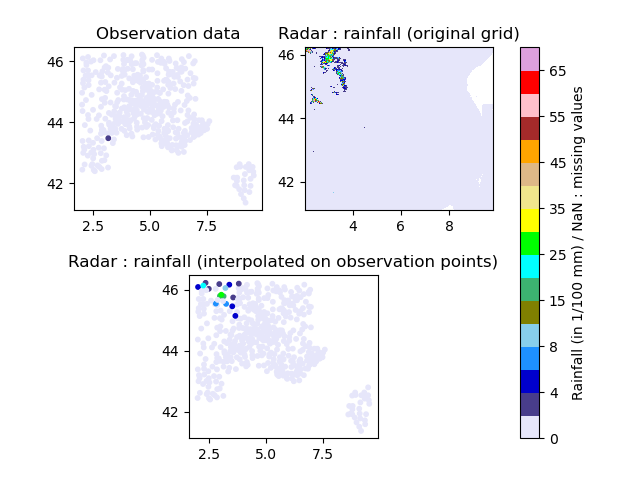

In [27]:
fig=plt.figure()
gs = gridspec.GridSpec(4, 4)

data_with_nan = data.astype(np.float64).copy()
data_with_nan[data_with_nan==-1]=np.nan

#colorbar definition for rainfall
max_rr = max(np.nanmax(data),np.nanmax(d_sub[obs_param]),np.nanmax(grid_val_on_points))
if (max_rr > 65):
    borne_max = np.max(data_to_interpolate[ori_param].values)
else:
    borne_max = 65 + 10
cmap = colors.ListedColormap(['lavender','darkslateblue', 'mediumblue','dodgerblue', 'skyblue','olive','mediumseagreen'
                              ,'cyan','lime','yellow','khaki','burlywood','orange','brown','pink','red','plum'])
bounds = [0,1,4,6,8,10,15,20,25,30,35,40,45,50,55,60,65,borne_max]
norm = colors.BoundaryNorm(bounds, cmap.N)

#observation data
ax1 = plt.subplot(gs[:2, :2])
plt.tight_layout(pad=3.0)
im=ax1.scatter(d_sub['lon'], d_sub['lat'], c=d_sub[obs_param], cmap=cmap,norm=norm, s = 10)
ax1.set_title('Observation data')

#rainfall data (original grid)
ax2 = plt.subplot(gs[:2, 2:])
ax2.pcolor(lon,lat,data_with_nan,cmap=cmap,norm=norm)
ax2.set_title('Radar : rainfall (original grid)')

#rainfall data (interpolated on observation points)
ax3 = plt.subplot(gs[2:4, 1:3])
ax3.scatter(latlon_obs[:,1], latlon_obs[:,0], c=grid_val_on_points, cmap=cmap,norm=norm, s = 10)
ax3.set_title('Radar : rainfall (interpolated on observation points)')

fig.colorbar(im,ax=[ax1,ax2,ax3]).set_label('Rainfall (in 1/100 mm) / NaN : missing values')
plt.show()